In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F

from utils.system import AAC
from utils.controller import  PID
from utils.dataset import Dataset
from utils.estimator import *


In [2]:
class WelfordNormalizerOne:
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, input_size=()):
        self.mean = np.zeros(input_size, 'float32')
        self.var = np.ones(input_size, 'float32')
        self.M2 = np.ones(input_size, 'float32')
        self.count = 1

    def update(self, x):
        #x = np.array(x)
        self.count += 1
        
        delta = x - self.mean
        
        self.mean += delta / self.count
        delta2 = x - self.mean
        self.M2 += delta * delta2
        res = self.normalize(x)
        return res
    
    def normalize(self, x):
        res = (x - self.mean) /  (self.M2 / (self.count ) )**(0.5)
        return res
    
    def denormalize(self, xn):
        res = xn * (self.M2 / (self.count ) )**(0.5) + self.mean
        return res


In [11]:
class OSELM_edited:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
                
        self.w_ik = 1*np.random.randn(input_dim,hidden_dim)
        self.P = np.zeros((2*self.hidden_dim, 2*self.hidden_dim))
        self.Omega = np.zeros((2*self.hidden_dim, self.output_dim))
    
    def predict(self, x, u, data_points = 1):
        H = []
        for n in range(data_points):   
            h = []
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(x[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))
                h.append(g) 
            
            for k in range(self.hidden_dim):
                g = []
                for i in range(self.input_dim):
                    g.append(x[n,i]* self.w_ik[i,k])
                g = sigmoid(np.sum(g))*u[n,0].item()
                h.append(g) 
            h = np.array(h)
            H.append(h)
            
        H = np.array(H)
        
        y = np.matmul(H, self.Omega)
        
        return y, H
        
    def predict_casadi(self,x, u):
        y = 0 

        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                g += x[i]* self.w_ik[i,k]

            g = sigmoid(g)
            y += self.Omega[k,0]*g
            
        for k in range(self.hidden_dim):
            g = 0
            for i in range(self.input_dim):
                g += x[i]* self.w_ik[i,k]

            g = sigmoid(g)
            y += self.Omega[self.hidden_dim +k,0]*g*u

        return y        
        
    def training_first(self, xs, us, ys):

        if xs.ndim > 2:
            xs = xs.squeeze()
        
        data_points, _ = np.shape(xs)

        _, H = self.predict(xs, us, data_points)
     
        # Calculate P0 and T0
        self.P = pinv2(np.matmul(H.T, H))
       
        self.Omega = np.matmul(self.P, np.matmul(H.T, ys))
        
        


    def training(self,x, u, y):
        _, H = self.predict(x, u)
        self.P = self.P - np.matmul(self.P, np.matmul(H.T, np.matmul(H, self.P))) / (1 + (np.matmul(H, np.matmul(self.P,H.T))))
        self.Omega = self.Omega + np.matmul( self.P, np.matmul(H.T, y - np.matmul(H, self.Omega)))


    def get_P(self):
        return self.P
    
    def get_Omega(self):
        return self.Omega
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class OSELM_nonaffine_:
    def __init__(self, input_dim, hidden_dim, output_dim, learned_ratio, dt):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim 
        self.dt = dt
        self.learned_ratio = learned_ratio

        self.e_fg = OSELM_edited(input_dim, hidden_dim, output_dim)

        self.train_input_x = []
        self.train_input_u = []
        self.train_output = []

        self.first_time = True


    def forward(self, x, u, t):
        if t / self.dt > self.learned_ratio*self.hidden_dim:
            dhe = self.e_fg.predict_casadi(np.array(x), u)
        else:
            dhe = 0

        return dhe


    def training(self, x, k, dhe_real, t, ef = 0, eg = 0):
        if t / self.dt < self.learned_ratio*self.hidden_dim:
            self.train_input_x.append(np.array(x))
            self.train_input_u.append([k])
            self.train_output.append([dhe_real]) # [ef, eg] = dhe * pinv(u_ext)
        else:
            if self.first_time:         
                self.e_fg.training_first(np.array(self.train_input_x),np.array(self.train_input_u), np.array(self.train_output))
                self.first_time = False
            else:
                self.e_fg.training(np.expand_dims(x, axis = 0),np.array([[k]]), dhe_real)

PYOSELM 
https://github.com/leferrad/pyoselm/blob/master/pyoselm/oselm.py
GELM is in OSELM
241 line shows predict

    # compute hidden layer activations
    H = self._create_random_layer().fit_transform(X)

    # compute output predictions for new hidden activations
    predictions = safe_sparse_dot(H, self.beta)
    
fit_transform belongs to sklearn as fit and transform. 
       if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)

https://github.com/leferrad/pyoselm/blob/master/pyoselm/layer.py

fit: line 86
    X = check_array(X, accept_sparse=True)
    self._generate_components(X)

    return self
        
transform: line 128
    X = check_array(X, accept_sparse=True)

    if len(self.components_) == 0:
        raise ValueError('No components initialized')

    return self._compute_hidden_activations(X)
        
._generate_components(X): line 365

    rs = check_random_state(self.random_state)
    if self._use_mlp_input:
        self._compute_biases(rs)
        self._compute_weights(X, rs)

self._compute_hidden_activations(X) : line 66

    def _compute_hidden_activations(self, X):
        """Compute hidden activations given X"""
        # compute input activations and pass them
        # through the hidden layer transfer functions
        # to compute the transform

        self._compute_input_activations(X)

        acts = self.input_activations_

        if callable(self.activation_func):
            args_dict = self.activation_args if self.activation_args else {}
            X_new = self.activation_func(acts, **args_dict)
        else:
            func_name = self.activation_func
            func = self._internal_activation_funcs[func_name]
            X_new = func(acts, **self._extra_args)


_compute_input_activations: line 377

    def _compute_input_activations(self, X):
        """Compute input activations given X"""

        n_samples = X.shape[0]

        mlp_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_mlp_input:
            b = self.components_['biases']

1

In [54]:
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *

class LCBF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_lead_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.g = 9.81
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_lead = v_lead_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
    def clf(self, x):
        v = x[1]        
        V = (v - self.v_des)**2
        return V

    def dclf(self, x, u, u_ref):
        v = x[1]
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))
        return dV
        
    def cbf(self, x, isMaxCD=False):
        v = x[1]
        z = x[2]
        if isMaxCD:
            h = z - self.Th * v - 0.5  * (self.v_lead - v)**2 / (self.cd * self.g)
        else:
            h = z - self.Th * v 
        return h
        
    def dcbf(self, x, u, isMaxCD=False):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        if isMaxCD:
            dh = 1/self.m * (self.Th + (v - self.v_lead)/self.cd/self.g ) * (Fr - u) + (self.v_lead - v)
        else:
            dh = self.Th/self.m * (Fr - u) + self.v_lead - v
        return dh


        
    def compute_controller(self, x, u_ref, estimator, weight, t = None, normalizer = None, u0 = 0):
        # Symbolic values
        u = SX.sym('u')
        slack = SX.sym('slack')

        # CBF-CLF calculation                
        V = self.clf(x) # Numeric
        dV = self.dclf(x, u, u_ref) # Symbolic

        h = self.cbf(x) # Numeric
        dh = self.dcbf(x, u) # Symbolic

        # Learning feed       
        if normalizer:
            x_n = normalizer['x'].update(x)
            u_n = normalizer['u'].normalize(u)
            
            
            dhe_n = estimator.forward(x_n, u_n, t)
            dhe = normalizer['dhe'].denormalize(dhe_n)
            dhe = taylor(dhe, u, u0, 2)  
        else:
            dhe = estimator.forward(x, u, t)

        # Estimator
        dS = dh + dhe
        
        # QP optimizer
        weight_input = 2/self.m**2
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, dS + self.cbf_rate * h)     
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        S = nlpsol('S', 'ipopt', qp,{'verbose':False,'print_time':False, "ipopt": {"print_level": 0}})
        r = S(lbg=0, lbx = -self.m*self.cd*self.g, ubx = self.m*self.ca*self.g)
        
        # Solutions
        if normalizer:
            k = r['x'].elements()[0]
            _ = normalizer['u'].update(k)
        else:
            k = r['x'].elements()[0]
        
        slack_sol = r['x'].elements()[1]

        # Create a Function to evaluate expression
        dh_f = Function('f',[u],[dh])
        dhe_f = Function('f',[u],[dhe])
        dV_f = Function('f',[u],[dV])
        dS_f = Function('f',[u],[dS])

        # Evaluate numerically
        dh = dh_f(k).elements()[0]
        dhe = dhe_f(k).elements()[0]
        dS = dS_f(k).elements()[0]
        dV = dV_f(k).elements()[0]

        return k, slack_sol, V, dV, h, dh, dhe, dS
    



class PID:
    def __init__(self, x_dim, u_dim, Kp, Kd, Ki, dT):
        self.x_dim = x_dim
        self.u_dim = u_dim 

        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        self.dT = dT
        
        self.e = np.zeros([x_dim,1])
        self.de = np.zeros([x_dim,1])
        self.ei = np.zeros([x_dim,1])
        
        # e(t-1) 
        self.e_1 = np.zeros([x_dim,1])
        
    def update(self, e):
        self.e = e
        
        # Compute derivative
        self.de = (self.e - self.e_1)/self.dT
        
        # Compute integral
        self.ei =  self.ei + self.dT*(self.e - self.e_1)/2
        
        u = self.Kp.dot(self.e) + self.Kd.dot(self.de)  + self.Ki.dot(self.ei)
        
        self.e_1 = self.e
        
        return u
        

    def reset(self):
        self.e = np.zeros([self.x_dim,1])
        self.de = np.zeros([self.x_dim,1])
        self.ei = np.zeros([self.x_dim,1])
        
        # e(t-1) 
        self.e_1 = np.zeros([self.x_dim,1])
        
        

In [4]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return np.array([p0, v0, z0])

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        
        return dx
    

In [39]:
dt = 0.01
simTime = 12

# Real parameters
v_lead = 22
v_des = 25
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0.
v0 = 22
z0 = 35


x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []

# Parameter ELM
n_hidden = 50

In [57]:
aac = AAC(m, c_d, f0, f1, f2, v_lead)

cont = LCBF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

derivator = Derivator(dt)

norm_x = WelfordNormalizerOne((3,))
norm_u = WelfordNormalizerOne((1,))
norm_dhe = WelfordNormalizerOne((1,))

normalizer = {'x':norm_x, 'u':norm_u, 'dhe':norm_dhe}

learned_ratio = 6 #2.5#1.6
estimator = OSELM_nonaffine(4, n_hidden, 1, learned_ratio, dt) # Change to 3

xs = []
us = []
Vs = []
hs = []
dhe_reals = []
dhes = []

slacks = []

weights = 0.2

train_input, train_output = [], []

train_input_x, train_input_u, train_output = [], [], []

x = sample_initial_state()


first_time = True

# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])
kd = np.array([[0, 0.1, 0]])
ki = np.array([[0, 1.0e3, 0]])

pid = PID(x_dim, u_dim, kp, kd, ki, dt)

if simTime / dt < learned_ratio*n_hidden:
    raise ValueError('simTime / dT: {} must be larger than n_hidden: {}'.format(simTime / dt, n_hidden))

pbar = tqdm(total=simTime/dt)

k = 0

for t in np.arange(0, simTime, dt): #simTime
    pbar.update(n=1)

    # Get reference control
    e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
    u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
    u_ref = u_ref[0,0]
    
    step = 0 if t>6.0 else 1
    
    aac.v_lead = v_lead + 0.8 * step #+ 1*np.sin(t) 1*np.sin(t) #
    aac.m = m + 500 * step
    #aac. = m + 500 * step
    
    
    # cont.v_lead =  v_lead + 0.8 * step #+ 0.5*np.sin(t)
    
    
    
    #print(k)
    k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights, t, normalizer, k) 
        

    # One step propagation in the system
    x_n = aac.update(x, k, t, dt)

    dh_real = derivator.update(h)

    dhe_real = dh_real - dh
    
    dhe_real_norm = normalizer['dhe'].update(dhe_real)
    x_norm = normalizer['x'].update(x)
    k_norm = normalizer['u'].update(k)

    
    estimator.training(x_norm, k_norm[0], dhe_real_norm[0], t)


    xs.append(x)
    us.append(k)
    Vs.append(V)
    hs.append(h)
    dhes.append(dhe)
    dhe_reals.append(dhe_real)
    slacks.append(slack_sol)
    
    x = x_n
        
        




  0%|          | 0/1200.0 [00:00<?, ?it/s]

  0%|          | 2/1200.0 [00:01<11:33,  1.73it/s]

  1%|          | 11/1200.0 [00:01<01:44, 11.36it/s]

  2%|▏         | 26/1200.0 [00:01<00:39, 29.98it/s]

  3%|▎         | 40/1200.0 [00:01<00:24, 47.28it/s]

  4%|▍         | 53/1200.0 [00:01<00:18, 62.43it/s]

  6%|▌         | 68/1200.0 [00:01<00:14, 80.45it/s]

  7%|▋         | 84/1200.0 [00:01<00:11, 97.69it/s]

  8%|▊         | 98/1200.0 [00:01<00:10, 107.95it/s]

  9%|▉         | 112/1200.0 [00:01<00:09, 114.36it/s]

 10%|█         | 126/1200.0 [00:02<00:09, 118.21it/s]

 12%|█▏        | 140/1200.0 [00:02<00:09, 115.08it/s]

 13%|█▎        | 154/1200.0 [00:02<00:08, 120.64it/s]

 14%|█▍        | 169/1200.0 [00:02<00:08, 127.86it/s]

 15%|█▌        | 183/1200.0 [00:02<00:07, 128.64it/s]

 17%|█▋        | 200/1200.0 [00:02<00:07, 139.11it/s]

 18%|█▊        | 215/1200.0 [00:02<00:06, 141.30it/s]

 19%|█▉        | 231/1200.0 [00:02<00:06, 145.94it/s]

 21%|██        | 248/1200.0 [00:02<

In [28]:
step = 0 if t>1 else 1

In [29]:
print(step)

0


In [27]:
t

9.99

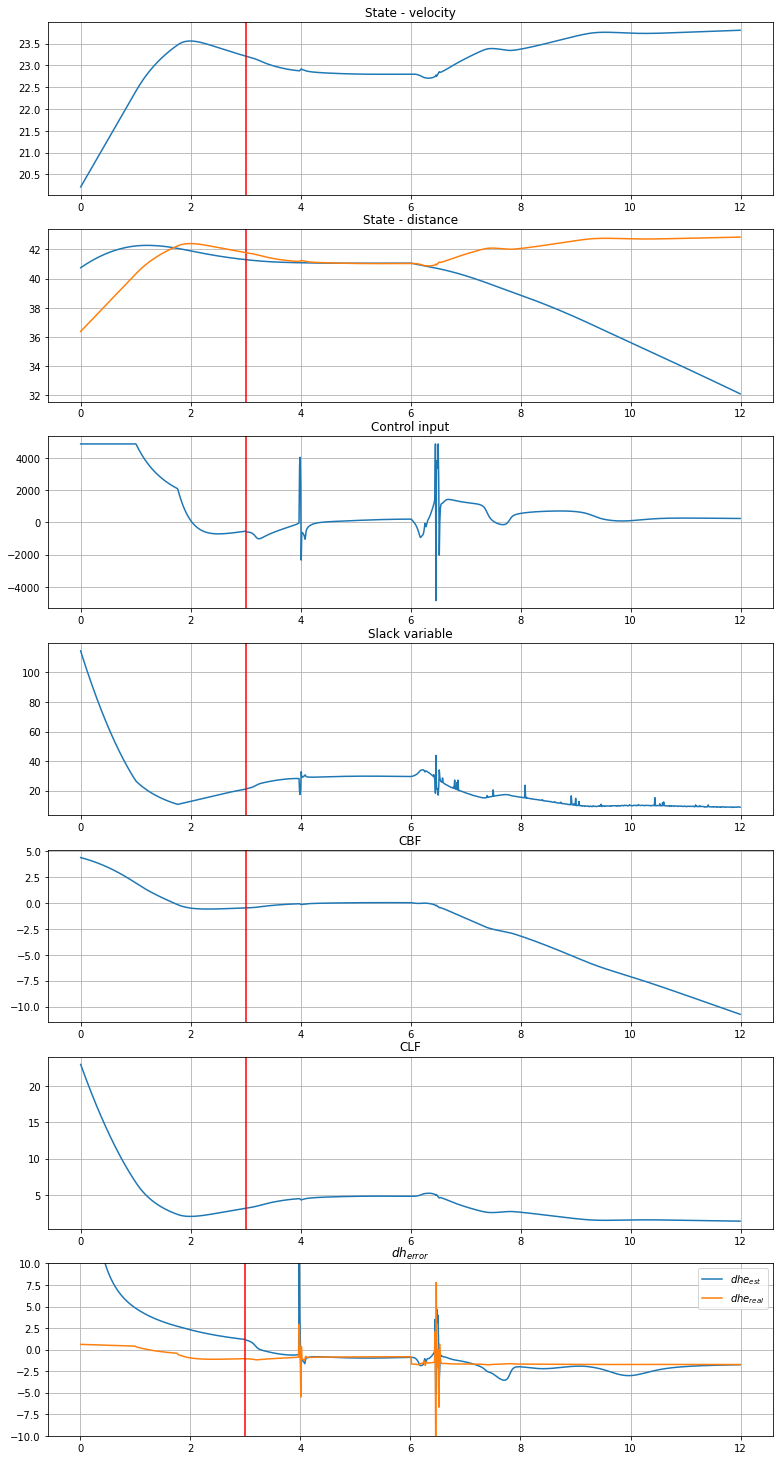



100%|██████████| 1200/1200.0 [00:35<00:00, 36.24it/s]

In [58]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')
ax[0].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns,  np.array(xs)[:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')
ax[1].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us))
ax[2].grid(True)
ax[2].set_title('Control input')
ax[2].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[3].plot(t_lns, np.array(slacks))
ax[3].grid(True)
ax[3].set_title('Slack variable')
ax[3].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[4].plot(t_lns, hs)
ax[4].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, Vs)
ax[5].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], dhes[1:])
ax[6].plot(t_lns[1:], dhe_reals[1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
ax[6].axvline(x = n_hidden*learned_ratio*dt, color = 'red')



ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])


NameError: name 'e_f_ests' is not defined

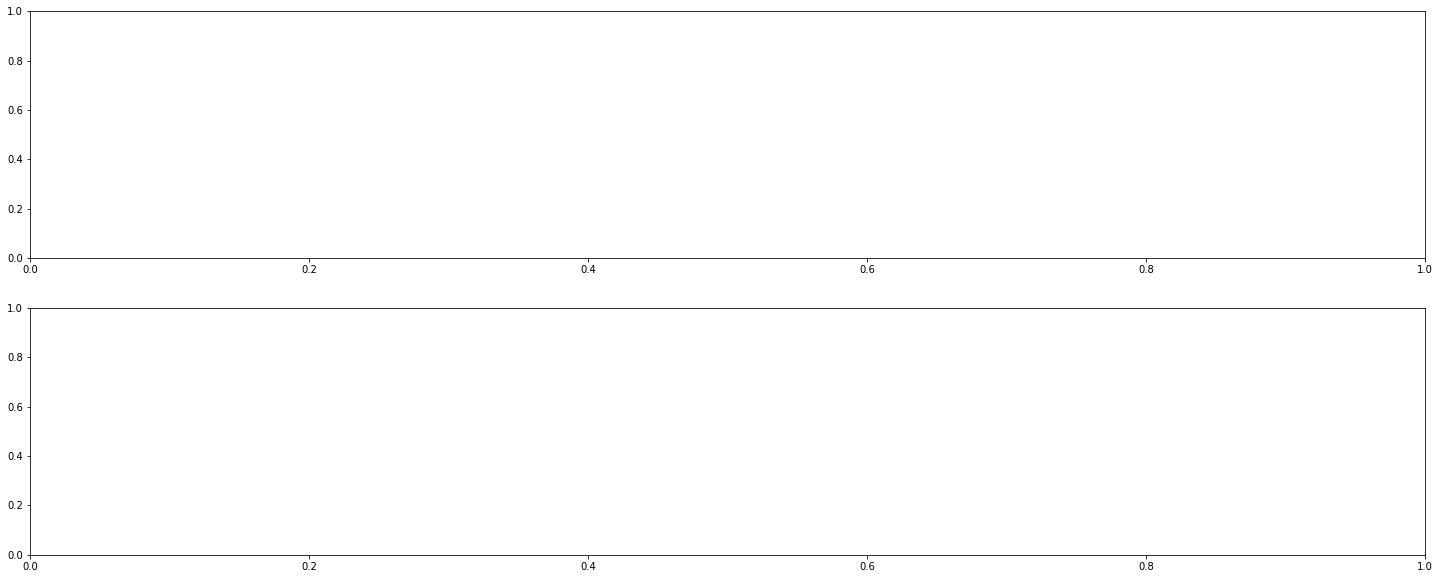










100%|██████████| 2000/2000.0 [00:49<00:00, 66.69it/s]

In [35]:
f,ax = plt.subplots(2,1,figsize = (25,10))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(e_f_ests))
ax[0].plot(t_lns, np.array(e_f_mins))
ax[0].plot(t_lns, np.array(e_f_reals))
ax[0].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[0].grid(True)
ax[0].set_title('$e_f$')
ax[0].legend(['$e_{f,est}$','$e_{f,min}$','$e_{f,real}$'], fontsize =14)
ax[0].set_ylim([-5,5])
#ax[0].set_ylim([-0.0001,0.0001])

ax[1].plot(t_lns, np.array(e_g_ests))
ax[1].plot(t_lns, np.array(e_g_mins))
ax[1].plot(t_lns, np.array(e_g_reals))
ax[1].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].grid(True)
ax[1].set_title('$e_g$')
ax[1].legend(['$e_{g,est}$','$e_{g,min}$','$e_{g,real}$'], fontsize =14)
ax[1].set_ylim([-0.005,0.005])

In [80]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)


n_hidden = 60
estimator = OSELMRegressor(n_hidden=n_hidden, activation_func='sigmoid', random_state=123)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
B_perf_lst = []
slack_lst = []


dBe_lst = []


x_initial = []
y_initial = []


x0 = sample_initial_state()
x = x0
derivator = Derivator(dt)


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    B_perfs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        dBe_est, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, estimator, weights)
        
        B_perf = x[2] - Th * x[1] - 0.5  * (v_ego - x[1])**2 / (c_d * 9.81)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        B_perfs.append(B_perf)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)
    B_perf_lst.append(B_perfs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        



NameError: name 'v_ego' is not defined

### No training

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

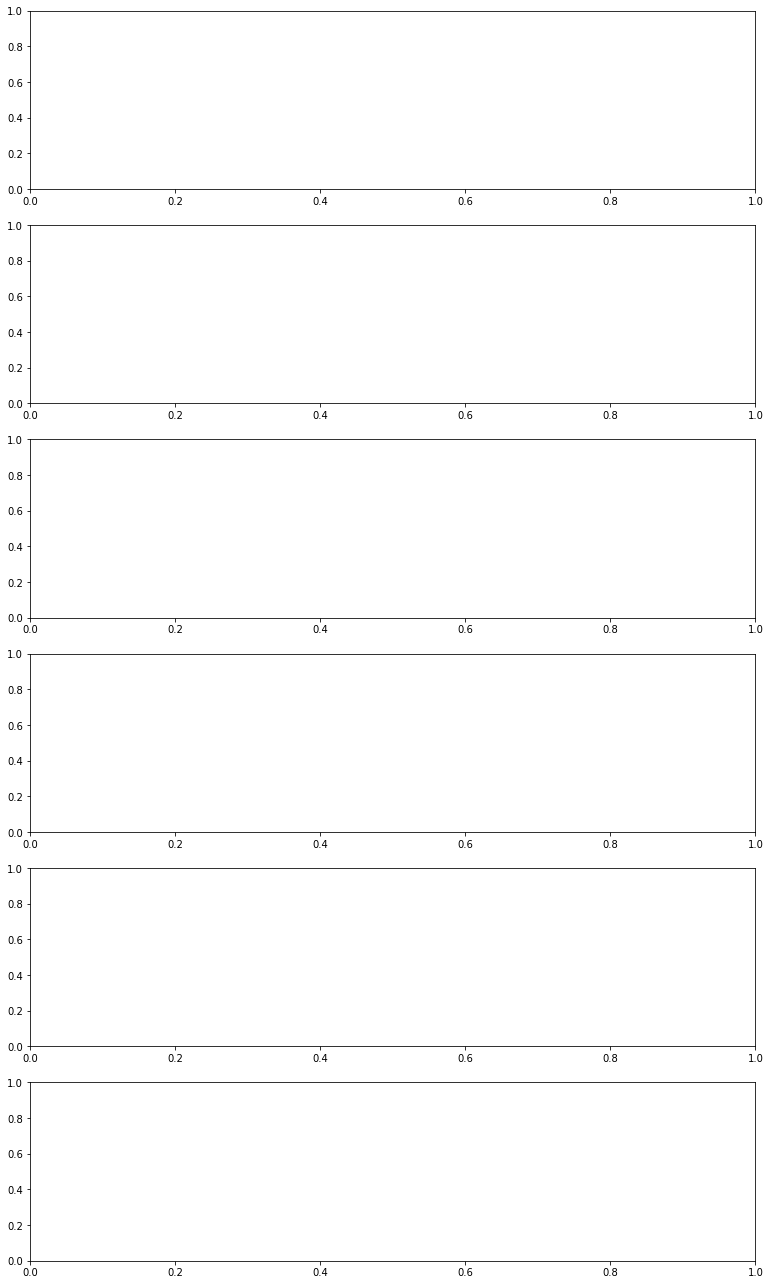

In [ ]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)
exp = 1


ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')


In [ ]:
t_lns.shape

(500,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

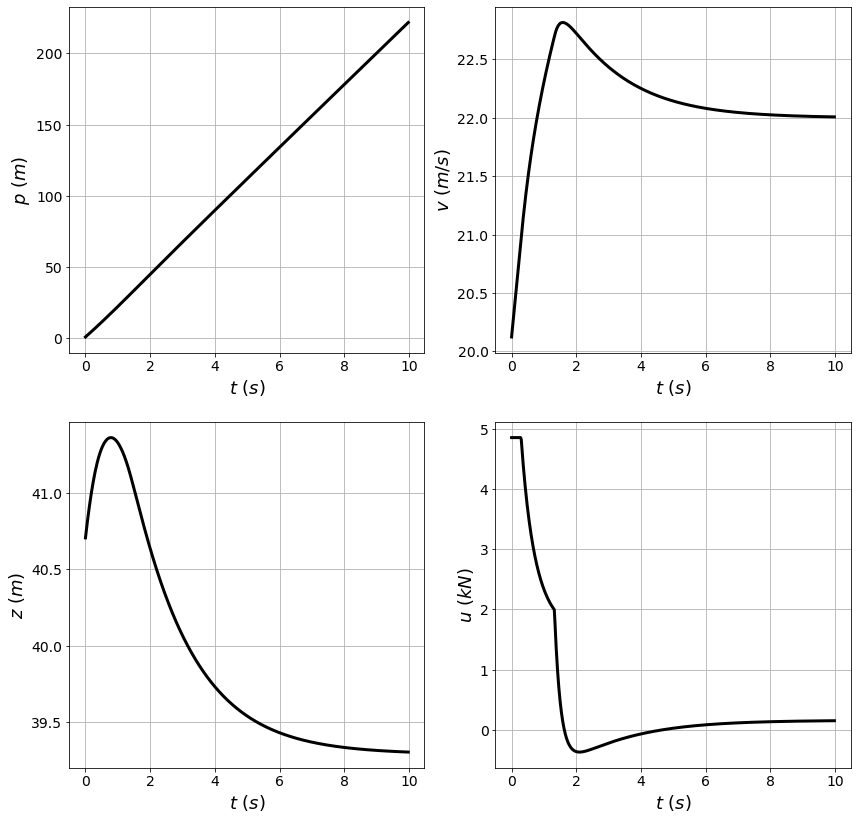

In [ ]:
f,ax = plt.subplots(2,2,figsize = (14,14))
t_lns = np.arange(0, 10, dt)
exp = 9

ax[0,0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0,0].grid(True)
ax[0,0].set_ylabel('$p$ $(m)$', fontsize = 18)
ax[0,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

ax[0,1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[0,1].grid(True)
ax[0,1].set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax[0,1].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,1].set_title('State - velocity')

ax[1,0].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[1,0].grid(True)
ax[1,0].set_ylabel('$z$ $(m)$', fontsize = 18)
ax[1,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[1,0].set_title('State - distance')

ax[1,1].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[1,1].grid(True)
ax[1,1].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[1,1].set_xlabel('$t$ $(s)$', fontsize = 18)
#ax[1,1].tick_params(fontsize=14)
plt.yticks(fontsize=14)
plt.setp(ax[0,0].get_xticklabels(), fontsize=14)
plt.setp(ax[0,0].get_yticklabels(), fontsize=14)

plt.setp(ax[0,1].get_xticklabels(), fontsize=14)
plt.setp(ax[0,1].get_yticklabels(), fontsize=14)

plt.setp(ax[1,0].get_xticklabels(), fontsize=14) 
plt.setp(ax[1,0].get_yticklabels(), fontsize=14)



plt.setp(ax[1,1].get_xticklabels(), fontsize=14)
plt.setp(ax[1,1].get_yticklabels(), fontsize=14)


#ax[1,1].set_title('State - distance')

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

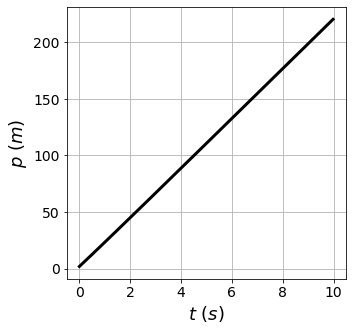

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 9

ax.plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$p$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

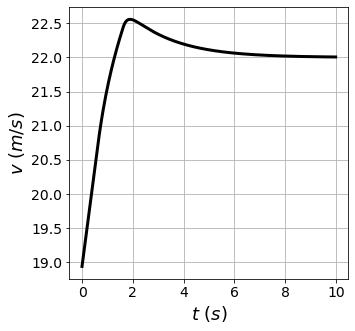

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([39.  , 39.25, 39.5 , 39.75, 40.  , 40.25, 40.5 , 40.75, 41.  ,
        41.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

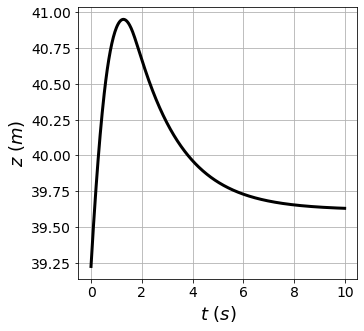

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,2], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$z$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

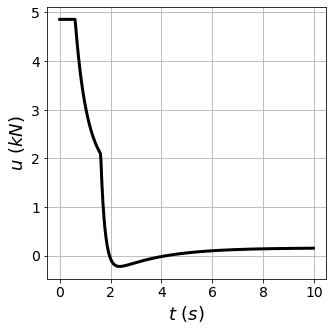

In [ ]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$u$ $(kN)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

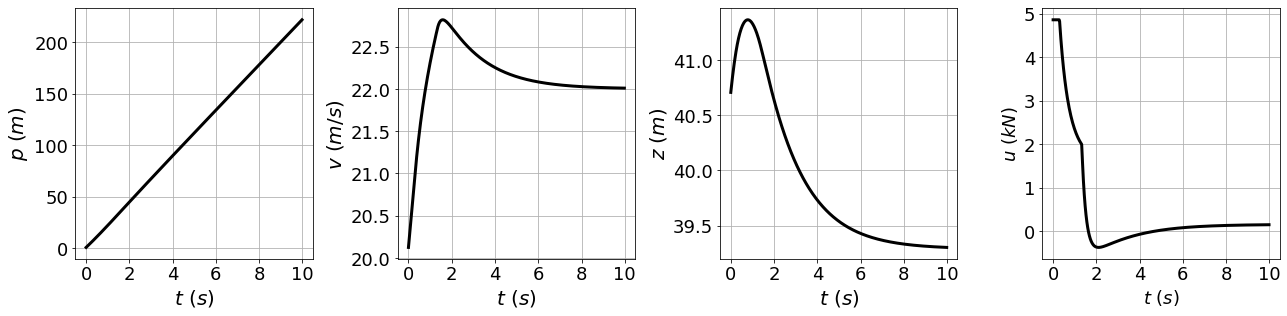

In [ ]:
f,ax = plt.subplots(1,4,figsize = (18,4.5))
t_lns = np.arange(0, 10, dt)
exp = 0

ax[0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0].grid(True)
ax[0].set_ylabel('$p$ $(m)$', fontsize = 20)
ax[0].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[1].grid(True)
ax[1].set_ylabel('$v$ $(m/s)$', fontsize = 20)
ax[1].set_xlabel('$t$ $(s)$', fontsize = 20)


ax[2].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[2].grid(True)
ax[2].set_ylabel('$z$ $(m)$', fontsize = 20)
ax[2].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[3].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[3].grid(True)
ax[3].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[3].set_xlabel('$t$ $(s)$', fontsize = 18)



plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)

plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

plt.setp(ax[2].get_xticklabels(), fontsize=18) 
plt.setp(ax[2].get_yticklabels(), fontsize=18)

plt.setp(ax[3].get_xticklabels(), fontsize=18)
plt.setp(ax[3].get_yticklabels(), fontsize=18)

f.tight_layout() 
#ax[1,1].set_title('State - distance')

### Barrier function

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

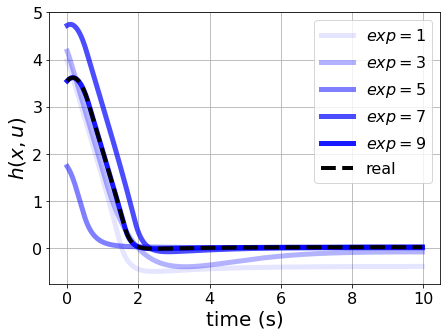

In [ ]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0



for exp in range(10):
    if exp % 2 == 0:
        h = np.array(x_lst)[exp,start:,2] - Th*np.array(x_lst)[exp,start:,1]  - 0.5*(np.array(x_lst)[exp,start:,1] - v_ego)/c_d/g
        h = np.array(B_lst)[exp,start:]
        ax.plot(t_lns[start:], h , 'blue', alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'black',linewidth = 4, linestyle = '--')

ax.grid(True)
#ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 20)
ax.set_ylabel('$h(x, u)$', fontsize= 20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



### Lyapunov function

Text(0, 0.5, '$V(x, u)$')

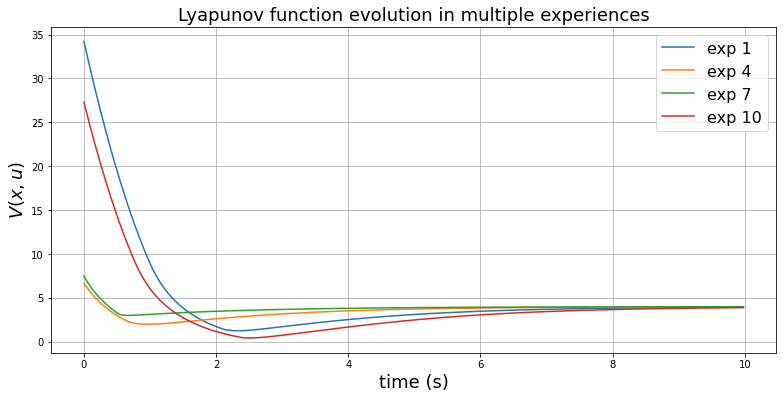

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 3 == 0:
        V = np.array(V_lst)[exp,start:]
        ax.plot(t_lns[start:], V )
        #print(exp)
        
ax.grid(True)
ax.set_title('Lyapunov function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

### Comparison with perfect knowledge

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

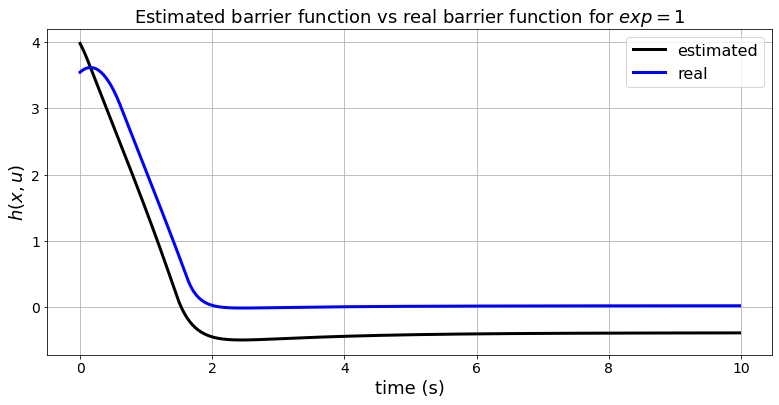

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 0

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'blue',linewidth = 3)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs real barrier function for $exp = 1$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

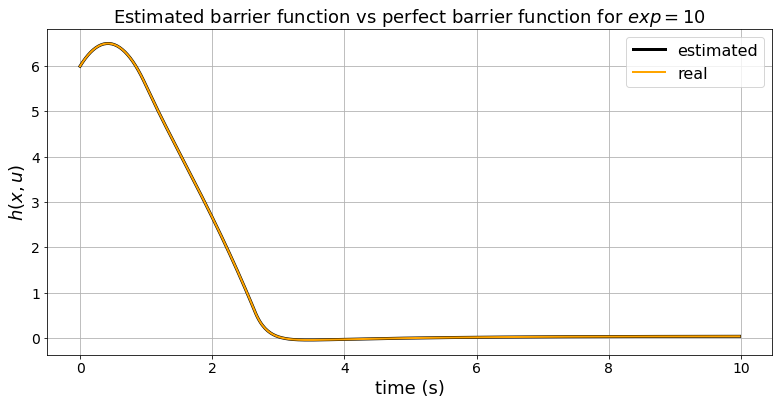

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'orange',linewidth = 2)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs perfect barrier function for $exp = 10$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Estimator evolution

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

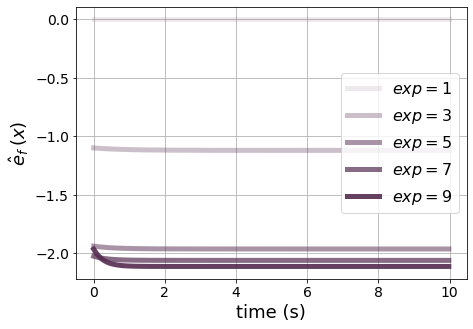

In [ ]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(a_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V , color = (0.329, 0.168, 0.313), alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_f$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_f\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,  0.    ,
         0.0005,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

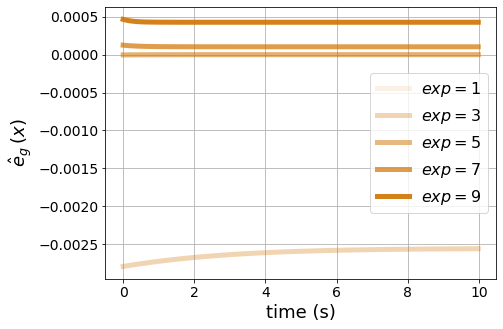

In [ ]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(b_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V, color = (0.819, 0.450, 0), alpha = 0.1 * (exp + 1), linewidth = 5 )
        #print(exp) 
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_g$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_g\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([35., 36., 37., 38., 39., 40., 41., 42., 43., 44.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

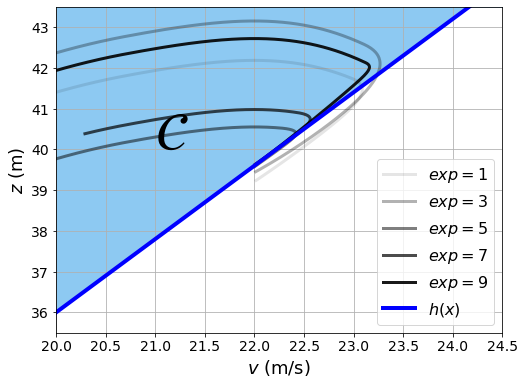

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

#h_perf = np.array(B_perf_lst)[exp,start:]

for exp in range(10):
    if exp % 2 == 0:
        z = np.array(x_lst)[exp,start:,2]# np.array(B_lst)[exp,start:]
        v = np.array(x_lst)[exp,start:,1]
        ax.plot(v, z, 'black', alpha = 0.1 * (exp + 1), linewidth = 3)
        

        
        
ax.grid(True)
#ax.set_title('Safe distance performance vs velocity. $z \geq T_h v$', fontsize= 18)
#ax.legend(['estimated','real'],fontsize= 16) 
ax.set_ylabel('$z$ (m)', fontsize= 18)
ax.set_xlabel('$v$ (m/s)', fontsize= 18)

v_min = 20
v_max = 24.5
z_min = 35.5
z_max = 43.5

v_span = np.linspace(v_min, v_max, 50)
ax.plot(v_span, v_span*Th, 'blue',linewidth = 4 )


ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','$h(x)$'],fontsize= 16) 
plt.gca().fill_between(v_span, v_span*Th, z_max, v_span > 0, color = (0.552, 0.788, 0.949))
ax.set_ylim(z_min, z_max)
ax.set_xlim(v_min, v_max)

ax.text(21,40,'$\mathcal{C}$', fontsize=54)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0

for exp in range(10):
    if exp % 3 == 0:
        h_ = np.array(B_perf_lst)[exp,start:]
        ax.plot(t_lns[start:], h )
        #print(exp)
        
ax.grid(True)
ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

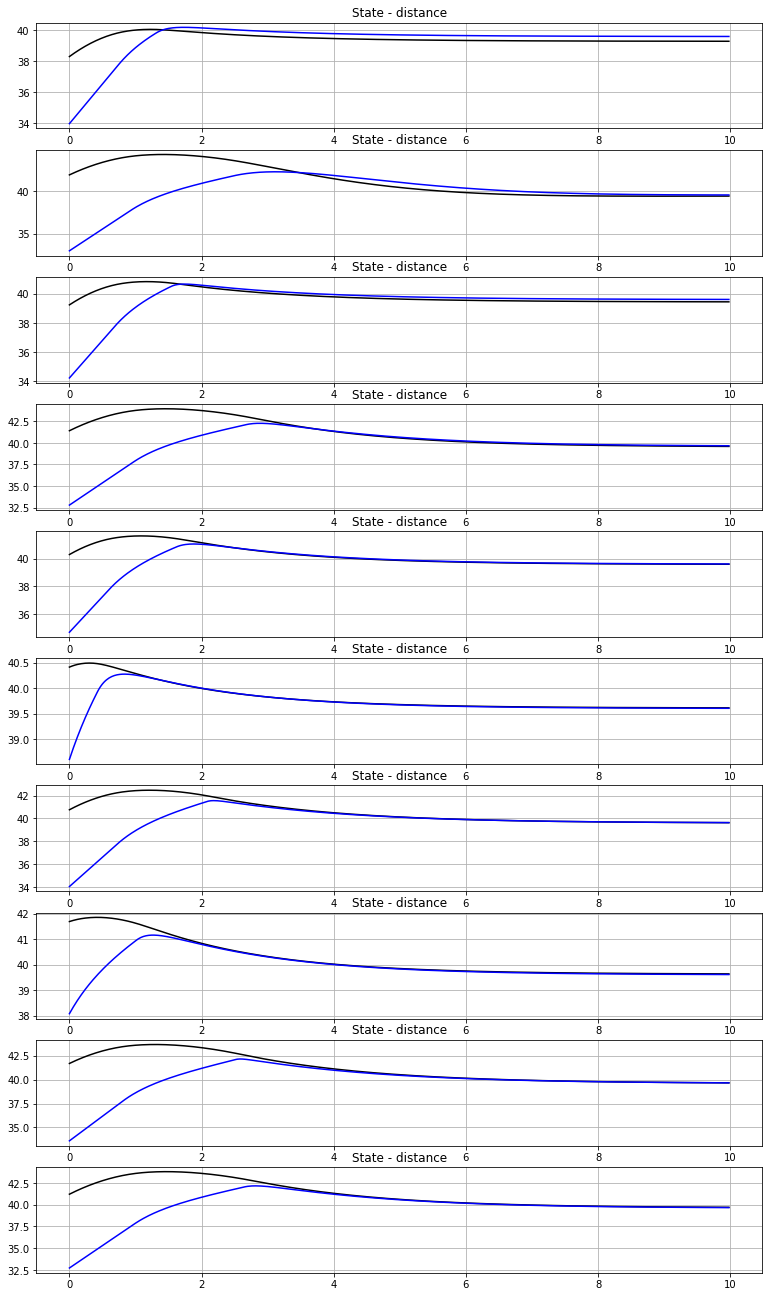

In [ ]:
f,ax = plt.subplots(10,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)

for exp in range(10):
    ax[exp].plot(t_lns, np.array(x_lst)[exp,:,2],'black')
    ax[exp].grid(True)
    ax[exp].set_title('State - distance')

    ax[exp].plot(t_lns, Th*np.array(x_lst)[exp,:,1], 'blue')

### First time

In [ ]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

A_h = Estimator(3)
A_h_opt = torch.optim.Adam(A_h.model.parameters(), lr = 1e-4)

B_h = Estimator(3)
B_h_opt = torch.optim.Adam(B_h.model.parameters(), lr = 1e-4)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


a_h_lst = []
b_h_lst = []


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    # Train
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
    
    # Test
    x = [0,20,40]
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
 
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) # dh_hat_i
        
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        

